In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass


In [2]:
from gemseo import configure_logger
from gemseo.algos.design_space import DesignSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo.disciplines.auto_py import AutoPyDiscipline
from numpy import array
from gemseo_oad_training.unit import convert_from

In [3]:
configure_logger()

<RootLogger root (INFO)>

**Création des disciplines**

In [4]:
l_disciplines = []
l_disciplines.append(AutoPyDiscipline(aerodynamic))
l_disciplines.append(AutoPyDiscipline(approach))
l_disciplines.append(AutoPyDiscipline(battery))
l_disciplines.append(AutoPyDiscipline(climb))
l_disciplines.append(AutoPyDiscipline(engine))
l_disciplines.append(AutoPyDiscipline(fuel_tank))
l_disciplines.append(AutoPyDiscipline(geometry))
l_disciplines.append(AutoPyDiscipline(mass))
l_disciplines.append(AutoPyDiscipline(mission))
l_disciplines.append(AutoPyDiscipline(operating_cost))
l_disciplines.append(AutoPyDiscipline(take_off))
l_disciplines.append(AutoPyDiscipline(total_mass))

**Création du desgin space**

In [5]:
class DesignSpacePB1(DesignSpace):
    def __init__(self):
        super().__init__(name="DSPB1")
        self.add_variable("slst", lower_bound=convert_from("kN",100), upper_bound=convert_from("kN",200), value=convert_from("kN",150.))
        self.add_variable("n_pax", lower_bound=120., upper_bound=180., value=150.)
        self.add_variable("area", lower_bound=convert_from("m2",100.), upper_bound=convert_from("m2",200.), value=convert_from("m2",180.))
        self.add_variable("ar", lower_bound=5, upper_bound=20., value=9.)


In [6]:
design_space_pb1 = DesignSpacePB1()

In [7]:
design_space_pb1

Name,Lower bound,Value,Upper bound,Type
slst,100000,150000,200000,float
n_pax,120,150,180,float
area,100,180,200,float
ar,5,9,20,float


In [8]:
scenario = MDOScenario(l_disciplines, "mtom", design_space_pb1, formulation_name="MDF")
scenario.add_constraint("tofl", constraint_type="ineq", positive=False,value=convert_from("m", 1900))
scenario.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from("kt", 135))
scenario.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from("ft/min", 300))
scenario.add_constraint("span", constraint_type="ineq", positive=False, value=convert_from("m", 40))
scenario.add_constraint("length", constraint_type="ineq", positive=False, value=convert_from("m", 45))
scenario.add_constraint("fm", constraint_type="ineq", positive=True, value=0)
scenario.add_constraint("fm", constraint_type="ineq", positive=False, value=100)




In [9]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 17:47:23: *** Start MDOScenario execution ***
    INFO - 17:47:23: MDOScenario
    INFO - 17:47:23:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:47:23:    MDO formulation: MDF
    INFO - 17:47:23: Optimization problem:
    INFO - 17:47:23:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:47:23:    with respect to ar, area, n_pax, slst
    INFO - 17:47:23:    subject to constraints:
    INFO - 17:47:23:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:47:23:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:47:23:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:47:23:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:47:23:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:47:23:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:47:23:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:47:23:    over the design space:
    INFO 

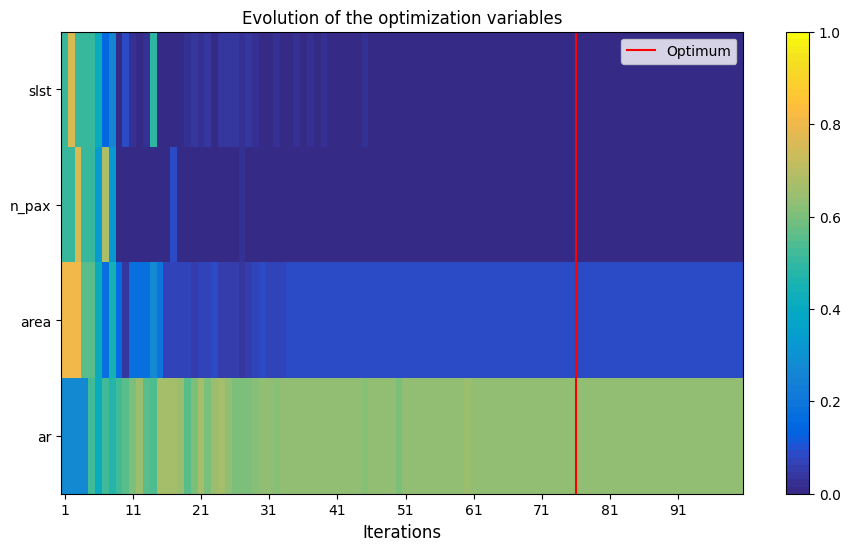

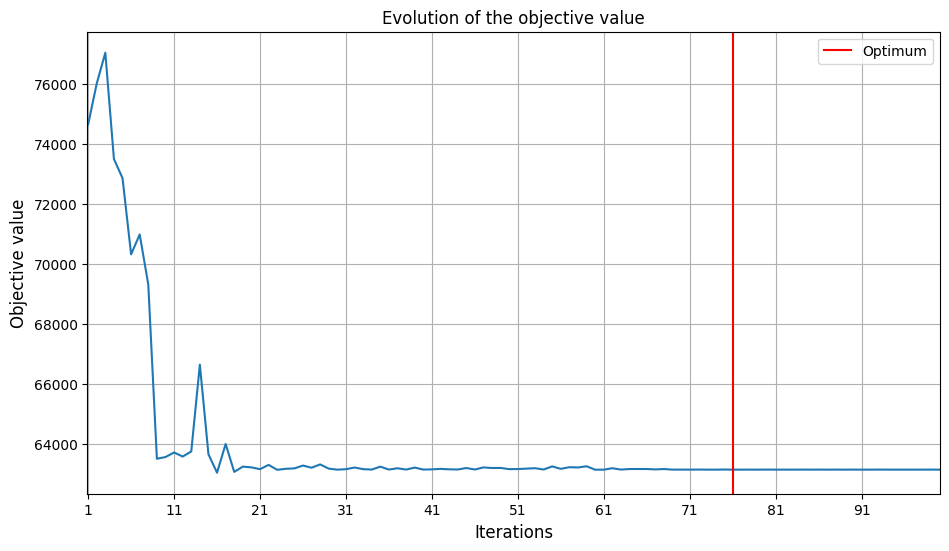

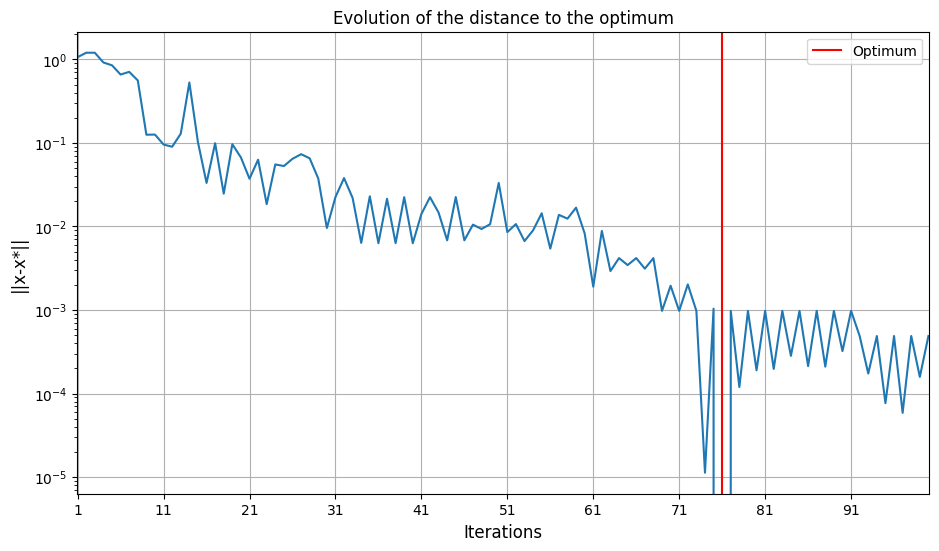

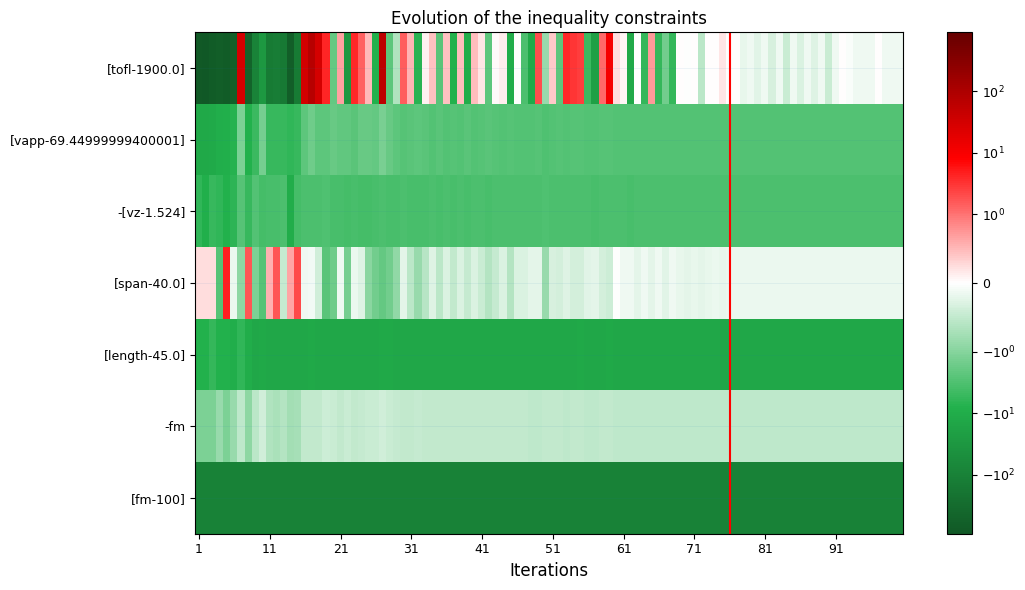

In [10]:
scenario.post_process(post_name="OptHistoryView", save=False, show=True)

Pour la suite : utiliser à la place des discipline s, smaple_discplines() -> "OT_OPT_LHS"  ou sobol ou halton
renvoye une surogate discpiline et remplacer dans MDO scenario la liste des discplines par la sugorate discpline

Surrogate

In [11]:
from gemseo.disciplines.surrogate import SurrogateDiscipline
from gemseo import sample_disciplines

In [12]:
training_dataset = sample_disciplines(l_disciplines, design_space_pb1, ["mtom", "tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_OPT_LHS", n_samples=20)

    INFO - 17:47:28: *** Start Sampling execution ***
    INFO - 17:47:28: Sampling
    INFO - 17:47:28:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:47:28:    MDO formulation: MDF
    INFO - 17:47:28: Running the algorithm OT_OPT_LHS:
    INFO - 17:47:29:    100%|██████████| 20/20 [00:00<00:00, 61.32 it/sec]
    INFO - 17:47:29: *** End Sampling execution (time: 0:00:00.343627) ***


In [13]:
test_dataset = sample_disciplines(l_disciplines, design_space_pb1, ["mtom", "tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_FULLFACT", n_samples=30)

    INFO - 17:47:29: *** Start Sampling execution ***
    INFO - 17:47:29: Sampling
    INFO - 17:47:29:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:47:29:    MDO formulation: MDF
    INFO - 17:47:29: Running the algorithm OT_FULLFACT:
    INFO - 17:47:29:    100%|██████████| 16/16 [00:00<00:00, 85.78 it/sec]s not exist; use 16 samples instead, i.e. the largest 4-th integer power less than 30.
    INFO - 17:47:29: *** End Sampling execution (time: 0:00:00.194562) ***


In [14]:
surrogate_discipline = SurrogateDiscipline("PolynomialRegressor", training_dataset)

In [15]:
scenario_surrogate = MDOScenario([surrogate_discipline], "mtom", design_space_pb1, formulation_name="MDF")
scenario_surrogate.add_constraint("tofl", constraint_type="ineq", positive=False,value=convert_from("m", 1900))
scenario_surrogate.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from("kt", 135))
scenario_surrogate.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from("ft/min", 300))
scenario_surrogate.add_constraint("span", constraint_type="ineq", positive=False, value=convert_from("m", 40))
scenario_surrogate.add_constraint("length", constraint_type="ineq", positive=False, value=convert_from("m", 45))
scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=True, value=0)
scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=False, value=100)




 WARNING - 17:47:30: No coupling in MDA, switching chain_linearize to True.


In [16]:
scenario_surrogate.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 17:47:30: *** Start MDOScenario execution ***
    INFO - 17:47:30: MDOScenario
    INFO - 17:47:30:    Disciplines: PolyReg_Sampling
    INFO - 17:47:30:    MDO formulation: MDF
    INFO - 17:47:30: Optimization problem:
    INFO - 17:47:30:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:47:30:    with respect to ar, area, n_pax, slst
    INFO - 17:47:30:    subject to constraints:
    INFO - 17:47:30:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:47:30:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:47:30:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:47:30:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:47:30:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:47:30:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:47:30:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:47:30:    over the design space:
    INFO - 17:47:30:       +-------+-------------+--------+-------------+-------+
    INFO - 17:47:30

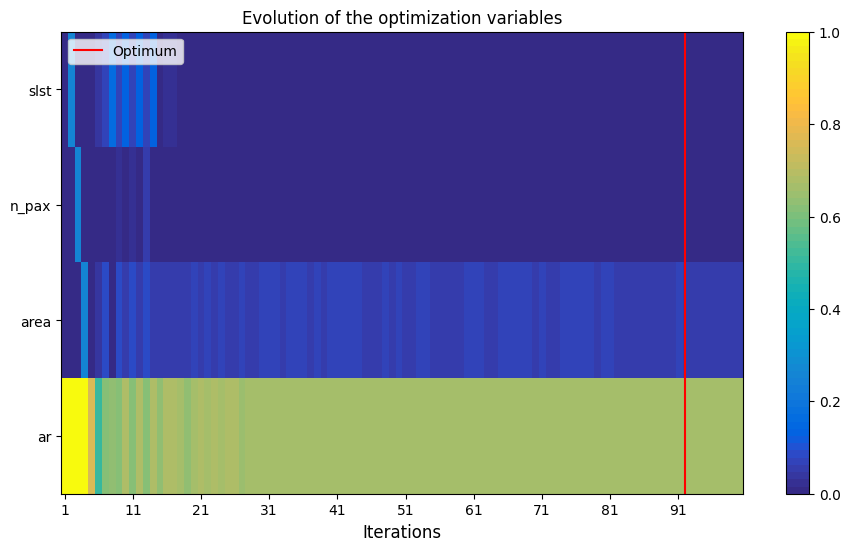

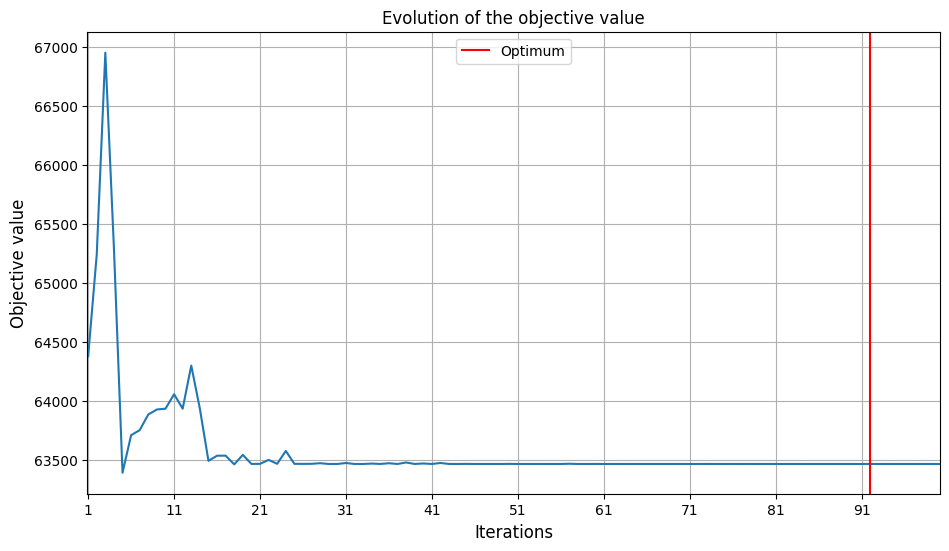

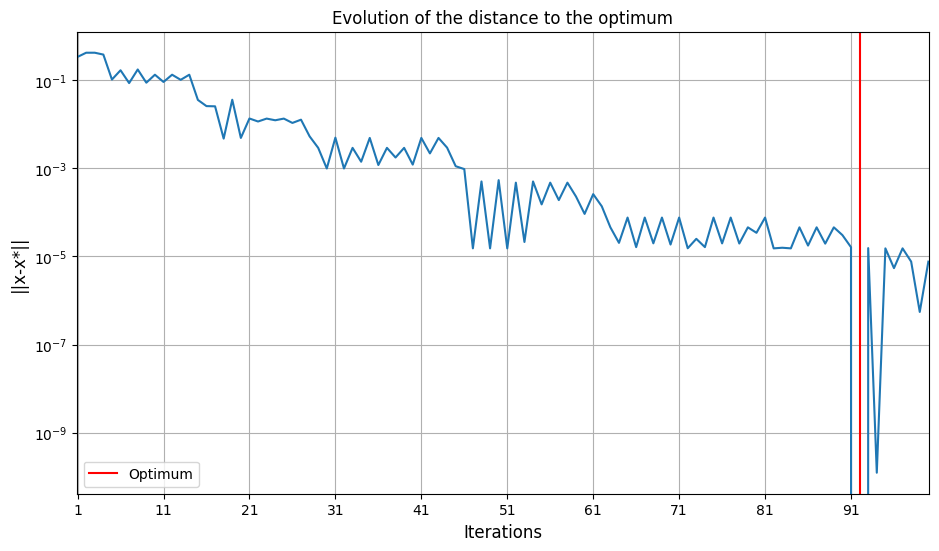

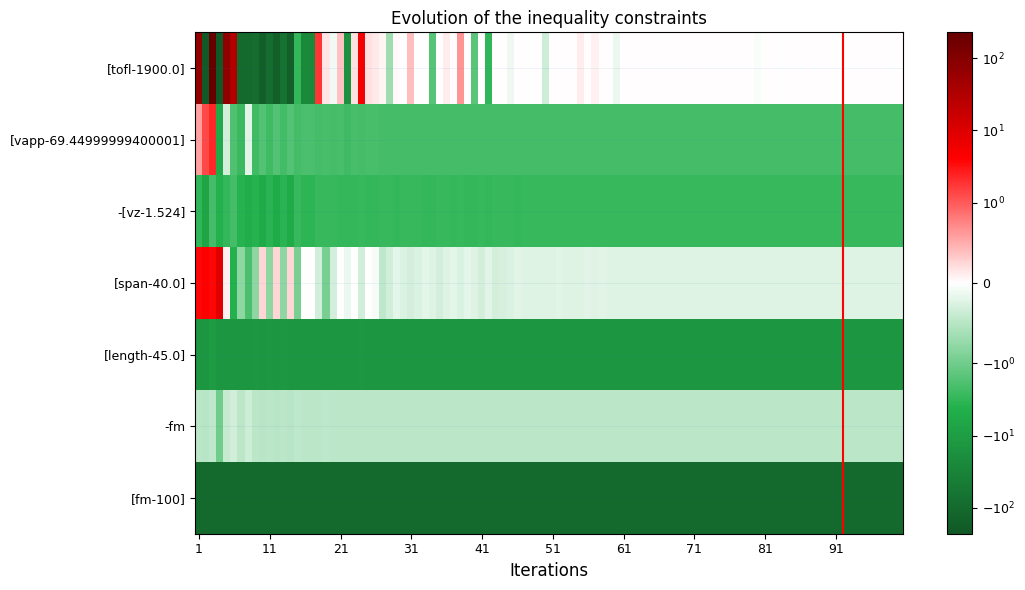

In [17]:
scenario_surrogate.post_process(post_name="OptHistoryView", save=False, show=True)

In [18]:
r2 = surrogate_discipline.get_error_measure("R2Measure")

In [19]:
r2.compute_cross_validation_measure(as_dict=True)

{'fm': array([0.99647277]),
 'length': array([1.]),
 'mtom': array([0.98373296]),
 'span': array([0.99661798]),
 'tofl': array([0.82029426]),
 'vapp': array([0.97946427]),
 'vz': array([0.9817863])}

In [20]:
r2.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([0.99501797]),
 'length': array([1.]),
 'mtom': array([0.97107788]),
 'span': array([0.99839314]),
 'tofl': array([0.93155136]),
 'vapp': array([0.99659897]),
 'vz': array([0.94700838])}

In [21]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")

In [22]:
rmse.compute_learning_measure(as_dict=True)

{'fm': array([0.00705973]),
 'length': array([1.02967425e-14]),
 'mtom': array([411.14046403]),
 'span': array([0.08047483]),
 'tofl': array([55.67450119]),
 'vapp': array([0.21350424]),
 'vz': array([0.96979433])}

In [23]:
scenario_surrogate.optimization_result.x_opt.reshape(1, -1)

array([[1.00000000e+05, 1.20000000e+02, 1.06249747e+02, 1.50126058e+01]])

In [24]:
#Vérification si le x optimal vérifie les contraintes (possible que non avec le model surrogate)
scenario.execute(algo_name="CustomDOE", samples=scenario_surrogate.optimization_result.x_opt.reshape(1, -1))

    INFO - 17:47:34: *** Start MDOScenario execution ***
    INFO - 17:47:34: MDOScenario
    INFO - 17:47:34:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:47:34:    MDO formulation: MDF
    INFO - 17:47:34: Optimization problem:
    INFO - 17:47:34:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:47:34:    with respect to ar, area, n_pax, slst
    INFO - 17:47:34:    subject to constraints:
    INFO - 17:47:34:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:47:34:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:47:34:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:47:34:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:47:34:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:47:34:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:47:34:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:47:34:    over the design space:
    INFO 

In [25]:
from gemseo_oad_training.utils import draw_aircraft
dict_result = scenario_surrogate.optimization_result.x_opt_as_dict
import re
length_val = None
span_val = None

for key, val in scenario_surrogate.optimization_result.constraint_values.items():
    match = re.search(r'\[(\w+)-([\d.]+)\]', key)
    if match:
        var_name, constraint_str = match.groups()
        constraint = float(constraint_str)
        real_value = val + constraint  # valeur réelle = valeur + contrainte
        if var_name == "length":
            length_val = real_value
        elif var_name == "span":
            span_val = real_value

length_mean = length_val if length_val else None
span_mean = span_val if span_val else None

print("Valeur réelle moyenne de length :", length_val)
print("Valeur réelle moyenne de span   :", span_val)

Valeur réelle moyenne de length : 31.999999999999996
Valeur réelle moyenne de span   : 39.77267936179266


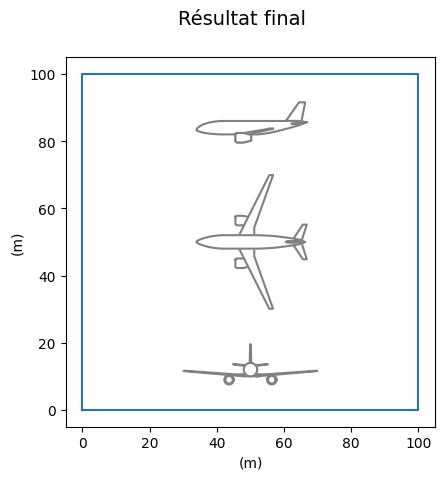

In [26]:
draw_aircraft(area=dict_result["area"][0],slst=dict_result["slst"][0], n_pax=dict_result["n_pax"][0],length=length_val, span=span_val, title="Résultat final")

In [ ]:
metamodels = [
 'GaussianProcessRegressor',
 'GradientBoostingRegressor',
 'LinearRegressor',
 'MLPRegressor',
 'PolynomialRegressor', 
 'RandomForestRegressor',
 'MOERegressor'
]

results = {}

for model_name in metamodels:
    print(f"model: {model_name}")

    # Créer la discipline de substitution
    surrogate_discipline = SurrogateDiscipline(model_name, training_dataset)

    # Définir un scénario MDO avec cette discipline
    scenario_surrogate = MDOScenario(
    [surrogate_discipline],
    formulation_name="MDF",
    objective_name="mtom",
    design_space=design_space_pb1
    )

    # Ajouter les contraintes
    scenario_surrogate.add_constraint("tofl", constraint_type="ineq", positive=False, value=convert_from("m", 1900))
    scenario_surrogate.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from("kt", 135))
    scenario_surrogate.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from("ft/min", 300))
    scenario_surrogate.add_constraint("span", constraint_type="ineq", positive=False, value=convert_from("m", 40))
    scenario_surrogate.add_constraint("length", constraint_type="ineq", positive=False, value=convert_from("m", 45))
    scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=True, value=0)
    scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=False, value=100)

    # Exécuter l'optimisation
    scenario_surrogate.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    # Évaluer la qualité via R² en validation croisée
    r2 = surrogate_discipline.get_error_measure("R2Measure")
    r2_result = r2.compute_test_measure(test_dataset, as_dict=True)

    results[model_name] = r2_result
    print(f" {model_name} -> R² (CV): {r2_result}")

# Enregistrement des résultats dans un fichier CSV
import os
import csv

os.makedirs("results_pb1_usecase1", exist_ok=True)
csv_path = "results_pb1_usecase1/benchmark.csv"
all_outputs = sorted({key for model in results.values() for key in model})

# Écriture CSV
with open(csv_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    
    # En-tête
    writer.writerow(["Model"] + all_outputs)
    
    for model_name, output_scores in results.items():
        row = [model_name]
        for output in all_outputs:
            value = output_scores.get(output)
            if value is not None:
                row.append(round(float(value), 6)) 
            else:
                row.append("N/A")
        writer.writerow(row)

model: GaussianProcessRegressor


 WARNING - 17:47:34: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:47:34: *** Start MDOScenario execution ***
    INFO - 17:47:34: MDOScenario
    INFO - 17:47:34:    Disciplines: GPR_Sampling
    INFO - 17:47:34:    MDO formulation: MDF
    INFO - 17:47:34: Optimization problem:
    INFO - 17:47:34:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:47:34:    with respect to ar, area, n_pax, slst
    INFO - 17:47:34:    subject to constraints:
    INFO - 17:47:34:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:47:34:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:47:34:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:47:34:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:47:34:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:47:34:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:47:34:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:47:34:    over the design space:
    INFO - 17:47:34:       +-

 GaussianProcessRegressor -> R² (CV): {'fm': array([0.92543809]), 'length': array([0.91961567]), 'mtom': array([0.89871483]), 'span': array([0.93311547]), 'tofl': array([0.77754538]), 'vapp': array([0.93833565]), 'vz': array([0.89781325])}
model: GradientBoostingRegressor


 WARNING - 17:47:36: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:47:36: *** Start MDOScenario execution ***
    INFO - 17:47:36: MDOScenario
    INFO - 17:47:36:    Disciplines: GradientBoostingRegressor_Sampling
    INFO - 17:47:36:    MDO formulation: MDF
    INFO - 17:47:36: Optimization problem:
    INFO - 17:47:36:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:47:36:    with respect to ar, area, n_pax, slst
    INFO - 17:47:36:    subject to constraints:
    INFO - 17:47:36:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:47:36:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:47:36:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:47:36:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:47:36:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:47:36:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:47:36:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:47:36:    over the design space:
    INF

 GradientBoostingRegressor -> R² (CV): {'fm': array([0.89703996]), 'length': array([0.98426744]), 'mtom': array([0.65734745]), 'span': array([0.9297634]), 'tofl': array([0.64557801]), 'vapp': array([0.86154166]), 'vz': array([0.79044732])}
model: LinearRegressor


    INFO - 17:47:40:     84%|████████▍ | 84/100 [00:01<00:00, 52.07 it/sec, obj=6.35e+4]
    INFO - 17:47:40: Optimization result:
    INFO - 17:47:40:    Optimizer info:
    INFO - 17:47:40:       Status: None
    INFO - 17:47:40:       Message: Successive iterates of the objective function are closer than ftol_rel or ftol_abs. GEMSEO stopped the driver.
    INFO - 17:47:40:       Number of calls to the objective function by the optimizer: 85
    INFO - 17:47:40:    Solution:
    INFO - 17:47:40:       The solution is feasible.
    INFO - 17:47:40:       Objective: 63524.40558311319
    INFO - 17:47:40:       Standardized constraints:
    INFO - 17:47:40:          -[vz-1.524] = -3.2213437807364906
    INFO - 17:47:40:          -fm = -0.4972546398471532
    INFO - 17:47:40:          [fm-100] = -99.50274536015284
    INFO - 17:47:40:          [length-45.0] = -13.0
    INFO - 17:47:40:          [span-40.0] = 1.4210854715202004e-14
    INFO - 17:47:40:          [tofl-1900.0] = -27.8523913

 LinearRegressor -> R² (CV): {'fm': array([0.92893981]), 'length': array([1.]), 'mtom': array([0.88737886]), 'span': array([0.96030547]), 'tofl': array([0.75222569]), 'vapp': array([0.96054516]), 'vz': array([0.89854749])}
model: MLPRegressor


    INFO - 17:47:42:     83%|████████▎ | 83/100 [00:01<00:00, 65.80 it/sec, obj=6.61e+4]
    INFO - 17:47:42: Optimization result:
    INFO - 17:47:42:    Optimizer info:
    INFO - 17:47:42:       Status: None
    INFO - 17:47:42:       Message: Successive iterates of the objective function are closer than ftol_rel or ftol_abs. GEMSEO stopped the driver.
    INFO - 17:47:42:       Number of calls to the objective function by the optimizer: 125
    INFO - 17:47:42:    Solution:
    INFO - 17:47:42:       The solution is feasible.
    INFO - 17:47:42:       Objective: 66117.05760843176
    INFO - 17:47:42:       Standardized constraints:
    INFO - 17:47:42:          -[vz-1.524] = -4.012681065916908
    INFO - 17:47:42:          -fm = -0.4581065526560349
    INFO - 17:47:42:          [fm-100] = -99.54189344734397
    INFO - 17:47:42:          [length-45.0] = -11.299538953327499
    INFO - 17:47:42:          [span-40.0] = -0.4613375939375146
    INFO - 17:47:42:          [tofl-1900.0] = 

 MLPRegressor -> R² (CV): {'fm': array([0.92094192]), 'length': array([0.95181619]), 'mtom': array([0.82765357]), 'span': array([0.8628714]), 'tofl': array([0.46956835]), 'vapp': array([0.72977554]), 'vz': array([0.86615128])}
model: PolynomialRegressor


    INFO - 17:47:44:    100%|██████████| 100/100 [00:01<00:00, 68.56 it/sec, obj=6.35e+4]
    INFO - 17:47:44: Optimization result:
    INFO - 17:47:44:    Optimizer info:
    INFO - 17:47:44:       Status: None
    INFO - 17:47:44:       Message: Maximum number of iterations reached. GEMSEO stopped the driver.
    INFO - 17:47:44:       Number of calls to the objective function by the optimizer: 102
    INFO - 17:47:44:    Solution:
    INFO - 17:47:44:       The solution is feasible.
    INFO - 17:47:44:       Objective: 63466.40425469066
    INFO - 17:47:44:       Standardized constraints:
    INFO - 17:47:44:          -[vz-1.524] = -2.8848155582425434
    INFO - 17:47:44:          -fm = -0.47020728847005994
    INFO - 17:47:44:          [fm-100] = -99.52979271152994
    INFO - 17:47:44:          [length-45.0] = -13.000000000000004
    INFO - 17:47:44:          [span-40.0] = -0.22795116493808365
    INFO - 17:47:44:          [tofl-1900.0] = 6.291860199780785e-05
    INFO - 17:47:44:

 PolynomialRegressor -> R² (CV): {'fm': array([0.99496985]), 'length': array([1.]), 'mtom': array([0.96984417]), 'span': array([0.99849626]), 'tofl': array([0.95861578]), 'vapp': array([0.99653398]), 'vz': array([0.97754527])}
model: RandomForestRegressor


 WARNING - 17:47:44: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:47:44: *** Start MDOScenario execution ***
    INFO - 17:47:44: MDOScenario
    INFO - 17:47:44:    Disciplines: RF_Sampling
    INFO - 17:47:44:    MDO formulation: MDF
    INFO - 17:47:44: Optimization problem:
    INFO - 17:47:44:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:47:44:    with respect to ar, area, n_pax, slst
    INFO - 17:47:44:    subject to constraints:
    INFO - 17:47:44:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:47:44:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:47:44:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:47:44:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:47:44:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:47:44:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:47:44:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:47:44:    over the design space:
    INFO - 17:47:44:       +--

 RandomForestRegressor -> R² (CV): {'fm': array([0.68132356]), 'length': array([0.66299684]), 'mtom': array([0.49075913]), 'span': array([0.57061599]), 'tofl': array([0.40337655]), 'vapp': array([0.66513875]), 'vz': array([0.3655849])}
model: MOERegressor


 WARNING - 17:47:45: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:47:45: *** Start MDOScenario execution ***
    INFO - 17:47:45: MDOScenario
    INFO - 17:47:45:    Disciplines: MoE_Sampling
    INFO - 17:47:45:    MDO formulation: MDF
    INFO - 17:47:45: Optimization problem:
    INFO - 17:47:45:    minimize mtom(slst, n_pax, area, ar)
    INFO - 17:47:45:    with respect to ar, area, n_pax, slst
    INFO - 17:47:45:    subject to constraints:
    INFO - 17:47:45:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 17:47:45:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 17:47:45:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 17:47:45:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 17:47:45:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 17:47:45:       fm(slst, n_pax, area, ar) >= 0
    INFO - 17:47:45:       fm(slst, n_pax, area, ar) <= 100
    INFO - 17:47:45:    over the design space:
    INFO - 17:47:45:       +-

 MOERegressor -> R² (CV): {'fm': array([0.86377322]), 'length': array([0.88245502]), 'mtom': array([0.85344871]), 'span': array([0.79582492]), 'tofl': array([0.40124693]), 'vapp': array([0.88229816]), 'vz': array([0.5186712])}
